# Inventory Optimization - Demo

In [1]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')

from inventory_optim.util import SyntheticInventoryData
from inventory_optim.data_model.constraints import Constraint
from inventory_optim.data_model.checker import Checker
from inventory_optim.optim_model.builder import ModelBuilder

## Synthetic Inventory Data

In [2]:
df = SyntheticInventoryData.generate()
df.head()

,id,category,region,store,quantity,unit_price,gross_margin,gross_profit
0,1,A,R1,16,100.0,6.418626,0.024696,0.158514
1,2,C,R1,20,24.0,7.311938,0.061032,0.446259
2,3,C,R1,9,378.0,2.872590,0.024932,0.071618
3,4,B,R2,2,5.0,5.242563,0.175776,0.921517
4,5,A,R2,13,5.0,0.500000,0.095255,0.047628


In [3]:
df.to_csv('../data/sample_data.csv', index=False)

### Quick Exploration

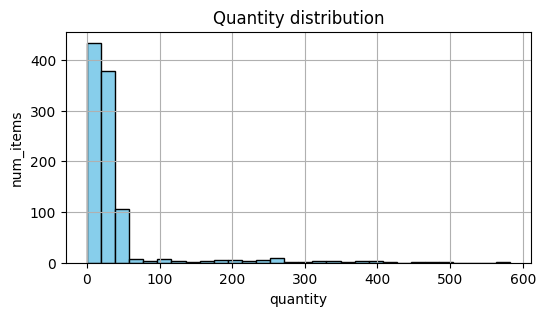

In [4]:
plt.figure(figsize=(6, 3))
df['quantity'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Quantity distribution')
plt.xlabel('quantity')
plt.ylabel('num_items')
plt.show()

Only a small portion of the inventory has a "quantity" higher than 50.

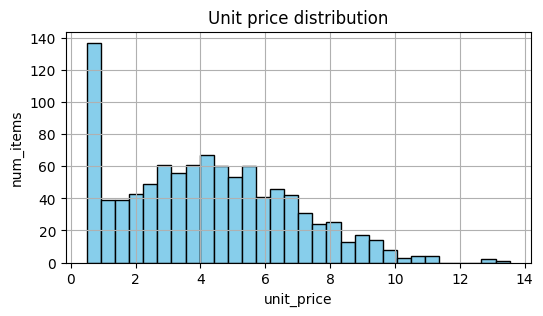

In [5]:
plt.figure(figsize=(6, 3))
df['unit_price'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Unit price distribution')
plt.xlabel('unit_price')
plt.ylabel('num_items')
plt.show()

"unit_price" follows a Gaussian distribution, with a peak of very cheap items. (result of the syntethic dataset generation).

In [6]:
df.groupby(by=['category'])['quantity'].sum()

category
A    12730.0
B    13085.0
C    12643.0
Name: quantity, dtype: float64

In [7]:
df['quantity'].sum()

38458.0

In [8]:
(df['quantity']*df['unit_price']*df['gross_margin']).sum()

12044.821176773192

In [9]:
(df['quantity']*df['unit_price']).sum()

170750.9210358158

In [10]:
df.groupby(by=['region'])['quantity'].sum()

region
R1    13118.0
R2    12966.0
R3    12374.0
Name: quantity, dtype: float64

In [11]:
df.groupby(by=['store'])['quantity'].sum()

store
1     1579.0
2     2413.0
3     1897.0
4     2347.0
5     2041.0
6     2639.0
7     2864.0
8     1180.0
9     1940.0
10    2657.0
11    2746.0
12    1162.0
13    1574.0
14    1879.0
15    1248.0
16    2677.0
17    1737.0
18    1150.0
19    1543.0
20    1185.0
Name: quantity, dtype: float64

In [12]:
df.groupby(by=['category'])['quantity'].sum()

category
A    12730.0
B    13085.0
C    12643.0
Name: quantity, dtype: float64

## Optimization

### Set constraints

In [13]:
store_1_target = round(df.groupby(by=['store'])['quantity'].sum()[1]*.85) # inventory quantity target for store 1: -15%
store_2_target = round(df.groupby(by=['store'])['quantity'].sum()[2]*1.15) # inventory quantity target for store 2: +15%
inventory_target = round(df['quantity'].sum()*1.1) # total inventory quantity target: + 10%

In [24]:
df['quantity'].sum()

38458.0

In [14]:
constraints = [
    Constraint(lb=store_1_target, ub=store_1_target, features=[{'name': 'store', 'values': [1]}]), 
    Constraint(lb=store_2_target, ub=store_2_target, features=[{'name': 'store', 'values': [2]}]), 
    Constraint(lb=inventory_target, ub=inventory_target, features=[]) 
]  # You can add/change/remove constraints

In [15]:
import json

In [16]:
with open('../data/sample_constraints.json', 'w') as json_file:
    json.dump({"constraints": constraints}, json_file)

### Run

In [17]:
mb = ModelBuilder()
mb.create_variables(df, var_incr=1.2, var_decr=.8, var_name='quantity')
mb.build_model(df, constraints, obj_feature_name="gross_profit", obj='max')
Checker.check_constraints(df, constraints, var_name='quantity')
is_ok, values = mb.solve()
df['opt'] = values

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 896 cols, 982 nonzeros
3 rows, 880 cols, 950 nonzeros
Presolve : Reductions: rows 3(-0); columns 880(-120); elements 950(-146)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          4    -1.4197514117e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  1.4197514117e+04
HiGHS run time      :          0.03


### Solution checks

In [18]:
import math

In [19]:
assert math.isclose(
    df[df['store'] == 1]['opt'].sum(),
    df.groupby(by=['store'])['quantity'].sum()[1]*.85,  # first constraint
    abs_tol=1
)

In [20]:
assert math.isclose(
    df[df['store'] == 2]['opt'].sum(),
    df.groupby(by=['store'])['quantity'].sum()[2]*1.15,  # second constraint
    abs_tol=1
)

In [21]:
assert math.isclose(
    df['opt'].sum(), 
    df['quantity'].sum()*1.1,  # third constraint
    abs_tol=1
)

In [22]:
print(f"new_gross_profit: {(df['opt'] * df['gross_profit']).sum():.2f}")

new_gross_profit: 14197.51


In [23]:
print(f"old_gross_profit: {(df['quantity'] * df['gross_profit']).sum():.2f}")

old_gross_profit: 12044.82
